In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from scipy.interpolate import interp1d
from scipy import misc
from scipy import optimize

# 1. Optimization: One dimensional root finding

Reference: http://people.duke.edu/~ccc14/sta-663-2016/11_OptimizationOneDimension.html

## 1.1 Bisection method

Derived from the intermediate value theorem: 
- If f(a) and f(b) have different signs and f is continous, then f must have a zero between a and b. 


### 1.1.1 Python example: bisection method

#### 1.1.1.1 Bisection method: scipy.optimize.bisect

In [2]:
f = lambda x: x**3 + 4*x**2 -3 #Non-linear function
x = np.linspace(-3.1, 0, 100) # X input for function
#Bisection method
optimize.bisect(f, -3, -.5, full_output=True)

(-1.0000000000006821,
       converged: True
            flag: 'converged'
  function_calls: 43
      iterations: 41
            root: -1.0000000000006821)

#### 1.1.1.2 Bisection method: user defined

In [3]:
f = lambda x: x**3 -x -2 #Non-linear function
def bisect_user(f, pt1, pt2, tolerance=.01, iterations=10):
    '''
    Params
    ---------
    f: function
    pt1, pt2: bisection points
    iterations: number of iterations to implement
    
    Returns
    ---------
    c: Polynomial root
    '''
    #Conditions: a<b:
    fpt1 = f(pt1)
    fpt2 = f(pt2)
    assert ( fpt1 < 0) & (fpt2  > 0) or ( fpt1 > 0) & (fpt2 < 0) 
    #Algo
    a = pt1
    b = pt2
    for n in range(1, iterations+1):
        c = (a+b)/2
        f_c = f(c)
        if tolerance > abs(f_c):
            return c
        if (f_c > 0) & (f(a)>0) or (f_c < 0) & (f(a) < 0): 
            a = c
        else:
            b = c
            
root = bisect_user(f, 1, 2, tolerance=.02, iterations=10)
print('One root of the input function: {}'.format(root))

One root of the input function: 1.5234375


#### 1.1.1.3 Analytical solution

In [4]:
from sympy import symbols, N, real_roots

x = symbols('x', real=True)
sol = real_roots(x**3 -x -2)
list(map(N, sol))

[1.52137970680457]

### 1.1.2 Graph bisection method

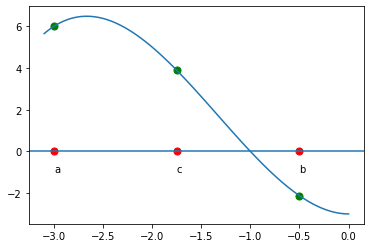

In [5]:
f = lambda x: x**3 + 4*x**2 -3
x = np.linspace(-3.1, 0, 100)
plt.plot(x, f(x))

a,b =  [-3.0, -0.5]
c = 0.5*(a+b)

plt.text(a,-1,"a")
plt.text(b,-1,"b")
plt.text(c,-1,"c")

plt.scatter([a,b,c], [f(a), f(b),f(c)], s=50, facecolors='green')
plt.scatter([a,b,c], [0,0,0], s=50, c='red')

xaxis = plt.axhline(0);

## 1.2 Secant method

- Similar to bisection method this also begins with two initial points
    - But unlike bisection the function values do not have to be opposite of signs. 



### 1.2.1 Python example: Secant method

#### 1.2.1.1 Bisection method: scipy.optimize.bisect

In [6]:
f = lambda x: (x**3-2*x+7)/(x**4+2)#Non-linear function
x = np.arange(-3,5, 0.1) # X input for function
#Secant method
optimize.root_scalar(f, x0=-1.2,x1=-.5, method='secant')

      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: -2.258258883402609

#### 1.2.1.1 Bisection method: user defined

In [7]:
def secant_method(f, x0, x1, iterations):
    for i in range(iterations):
        x2 = x1 - f(x1) * (x1 - x0) / float(f(x1) - f(x0))
        x0, x1 = x1, x2
    return x2


root = secant_method(f, -1.2, -.5, 5)
root

-2.2559321208994207

## 1.3 Newton-Rhapson
- Converges quadratically
- If the quadratic approximation is reasonably good, Newton_rhapson should converge to the local maximum more quickly than the steepest-ascent.


$$\theta_n = \theta_{n-1} - \frac{g(\theta_{n-1})}{g'(\theta_{n-1})}$$

- Basins of attraction and horizontal asymptotes can prevent convergence

In [8]:
def newtonrhap(f, x, tolerance=0.001):
    while True:
        #Newton-rap algo
        x1 = x - f(x) / misc.derivative(f, x) 
        #Check to see if we improved estimate of root
        t = abs(x1 - x)
        if t < tolerance:
            break
        x = x1
    return x

In [9]:
f = lambda x: (x**3-2*x+7)/(x**4+2)
x = -1.5
x0 = newtonrhap(f, x)

print('Initial guess:', x)
print('x0: ', round(x0,5))
print("f(x0) = ", round(f(x0),5))

Initial guess: -1.5
x0:  -2.25704
f(x0) =  0.00058


## 1.4 Brent's method

- Combination of bisection, secant and inverse quadratic interpolation

In [10]:
f = lambda x: (x - 2) * x * (x + 2)**2
scipy.optimize.brentq(f,-1,.5)

-7.864845203343107e-19

# 2. Optimization: Multi-dimensional
- Reference http://people.duke.edu/~ccc14/sta-663-2016/12_MultivariateOptimizationAlgorithms.html


## 2.1 Basics
### 2.1.1 Gradient and Hessian

The first derivative of a matrix is an n×1 vector called the gradient 

$$\begin{split}\nabla f(x) = \left(\begin{matrix}\frac{\partial f}{\partial x_1}\\ \vdots \\\frac{\partial f}{\partial x_n}\end{matrix}\right)\end{split}$$ 

The second derivative is an n×n matrix called the Hessian 

$$
H=\begin{bmatrix}
  \dfrac{\partial^2 f}{\partial x_1^2} & \dfrac{\partial^2 f}{\partial x_1\,\partial x_2} & \cdots & \dfrac{\partial^2 f}{\partial x_1\,\partial x_n} \\[2.2ex]
  \dfrac{\partial^2 f}{\partial x_2\,\partial x_1} & \dfrac{\partial^2 f}{\partial x_2^2} & \cdots & \dfrac{\partial^2 f}{\partial x_2\,\partial x_n} \\[2.2ex]
  \vdots & \vdots & \ddots & \vdots \\[2.2ex]
  \dfrac{\partial^2 f}{\partial x_n\,\partial x_1} & \dfrac{\partial^2 f}{\partial x_n\,\partial x_2} & \cdots & \dfrac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}
$$

#### 2.1.1.1 Python example: Hessian with Sympy

In [11]:
from sympy import symbols, hessian, Function, init_printing, expand, Matrix, diff
x, y, z = symbols('x y z')
f = symbols('f', cls=Function)
init_printing()

In [12]:
f = x**2 + 2*y**2 + 3*z**2 + 2*x*y + 2*x*z
f

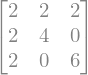

In [13]:
H = hessian(f, (x, y, z))
H

In [14]:
eigs = np.linalg.eigvals(np.array(H).astype('float'))>0
if not any(eigs)==True:
    print('Not convex')
else:
    print('All eigenvalues>0, Hessian is positive definite')

All eigenvalues>0, Hessian is positive definite


### 2.1.2 Convexity

#### 2.1.2.1 Python example: Check for convexity 
Reference: [CVXPY library](https://www.cvxpy.org/index.html)

In [15]:
import cvxpy as cp

# Problem data.
m = 30
n = 20
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A*x - b))
prob = cp.Problem(objective)
prob

Problem(Minimize(Expression(CONVEX, NONNEGATIVE, ())), [])

## 2.3 Line search
Reference: [Scipy library](https://scipy.github.io/devdocs/generated/scipy.optimize.line_search.html)

In [16]:
test_func = lambda x: (x[0])**2+(x[1])**2
test_grad = lambda x: [2*x[0],2*x[1]]
start_point = np.array([1.8, 1.7])
search_gradient = np.array([-1.0, -1.0])
alpha, func_evals, gradient_evals, new_func, old_func, new_slope = scipy.optimize.line_search(test_func,test_grad, start_point, search_gradient)

In [17]:
alpha, func_evals, gradient_evals, new_func, old_func, new_slope = scipy.optimize.line_search(test_func,test_grad,np.array([1.8,1.7]),np.array([-1.,-1.]))
new_func

## 2.4 Steepest descent

$$f(x) = \frac12 x^TQx - b^Tx \\ 
\nabla f = Qx -b$$


Steepest descent with step size:
$$f(x_k - \alpha \nabla f_k) = \frac12\left(x_k - \alpha \nabla f_k\right)^TQ\left(x_k - \alpha \nabla f_k\right) - b^T \left(x_k - \alpha \nabla f_k\right)$$

Differentiate w.r.t $\alpha$ and find the zero
$$\alpha_k = \frac{\nabla f_k^T\nabla f_k}{\nabla f_k^TQ\nabla f_k}$$

## 2.5 Newton's method

$$p_k = -H^{-1}\nabla f_k$$

In [18]:
Quad = lambda x: (x[1:])**2.0 + 5*(x[:-1])**2.0
DQuad = lambda x,y: np.array([2.0*x,10.0*y])

In [19]:
x = np.linspace(-20,20, 100)
y = np.linspace(-20,20, 100)
X, Y = np.meshgrid(x, y)
Z = Quad(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
Hinv=-np.array([[0.5,0],[0,0.1]])

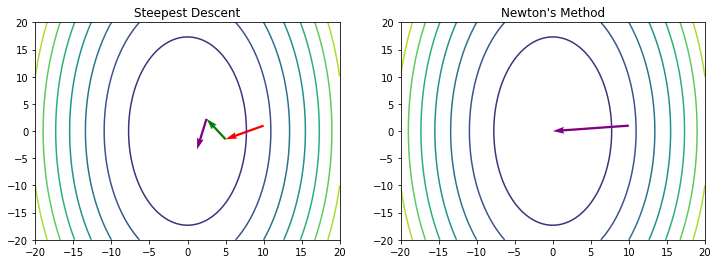

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X,Y,Z);

#Steepest descent
plt.title("Steepest Descent");
step=-0.25 #Step size
X0,Y0  = [10.0, 1.0] #Starting point
sgrad = step*DQuad(X0,Y0) #Gradient
plt.quiver(X0,Y0,sgrad[0],sgrad[1],color='red',angles='xy',scale_units='xy',scale=1);
X1 = X0 + sgrad[0]
Y1 = Y0 + sgrad[1]
sgrad = step*DQuad(X1,Y1)
plt.quiver(X1,Y1,sgrad[0],sgrad[1],color='green',angles='xy',scale_units='xy',scale=1);
X2 = X1 + sgrad[0]
Y2 = Y1 + sgrad[1]
sgrad = step*DQuad(X2,Y2)
plt.quiver(X2,Y2,sgrad[0],sgrad[1],color='purple',angles='xy',scale_units='xy',scale=1);


#Newton's method
Ngrad=Hinv.dot(DQuad(X0,Y0))
plt.subplot(122)
plt.contour(X,Y,Z);
plt.title("Newton's Method")
plt.quiver(X0,Y0,Ngrad[0],Ngrad[1],color='purple',angles='xy',scale_units='xy',scale=1);


### 2.6.1 Newton CG


In [23]:
from scipy import optimize as opt
from scipy.optimize import rosen, rosen_der, rosen_hess
x0 = np.array([4,-4.1])
ps = [x0]
opt.minimize(rosen, x0, method='Newton-CG', jac=rosen_der, callback=reporter)

     fun: 7.483142654194713e-13
     jac: array([ 0.00029295, -0.00014705])
 message: 'Optimization terminated successfully.'
    nfev: 40
    nhev: 0
     nit: 27
    njev: 148
  status: 0
 success: True
       x: array([0.99999914, 0.99999827])

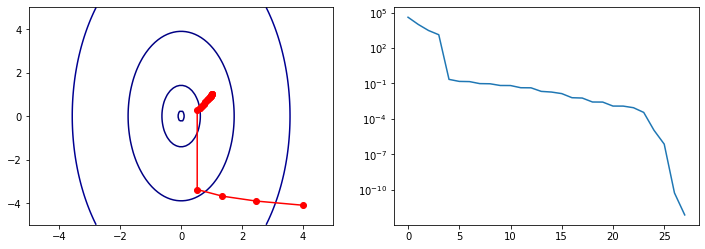

In [24]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

### 2.6.2 BFGS - Broyden–Fletcher–Goldfarb–Shanno

- "Quasi" Newton method
- Variants of Newton where Hessian is replaced by an approximation

In [25]:
def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    global ps
    ps.append(p)

In [26]:
from scipy import optimize as opt
from scipy.optimize import rosen, rosen_der, rosen_hess
x0 = np.array([4,-4.1])
ps = [x0]
opt.minimize(rosen, x0, method='BFGS', callback=reporter)

      fun: 9.48988612333806e-12
 hess_inv: array([[0.49995593, 0.99988908],
       [0.99988908, 2.00468039]])
      jac: array([ 4.39252450e-05, -2.03651389e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 540
      nit: 56
     njev: 132
   status: 2
  success: False
        x: array([0.99999712, 0.99999413])

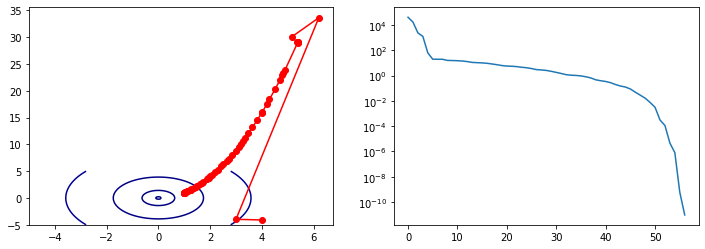

In [27]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

### 2.6.3 Nelder-mead simplex

- Nelder-Mead is a zero-order method (no derivatives necessary)
    - Requires only function itself 
    


In [28]:
ps = [x0]
opt.minimize(rosen, x0, method='nelder-mead', callback=reporter)

 final_simplex: (array([[0.99998846, 0.99997494],
       [0.99994401, 0.99989075],
       [1.0000023 , 1.0000149 ]]), array([5.26275688e-10, 3.87529507e-09, 1.06085894e-08]))
           fun: 5.262756878429089e-10
       message: 'Optimization terminated successfully.'
          nfev: 162
           nit: 85
        status: 0
       success: True
             x: array([0.99998846, 0.99997494])

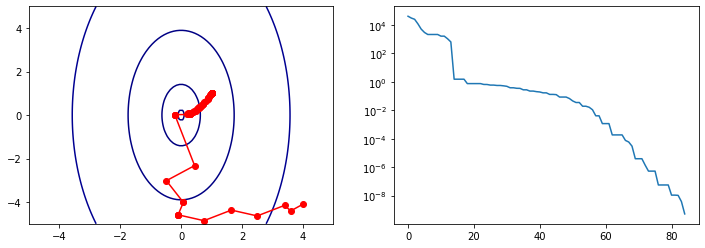

In [29]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

### 2.6.4 Powell's method

In [30]:
ps = [x0]
opt.minimize(rosen, x0, method='Powell', callback=reporter)

   direc: array([[3.62381017e-02, 7.42105813e-02],
       [3.31274020e-09, 5.93345832e-09]])
     fun: 2.4158865222393487e-30
 message: 'Optimization terminated successfully.'
    nfev: 535
     nit: 18
  status: 0
 success: True
       x: array([1., 1.])

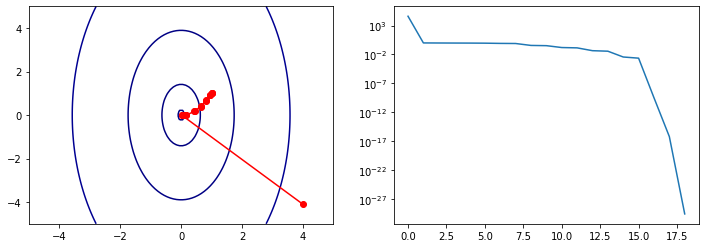

In [31]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

# 3. Local & global minima

## 3.1 One dimensional minimization
### 3.1.1 Random start point
- Yields only local minimum

In [32]:
f = lambda x, offset: -np.sinc(x-offset)

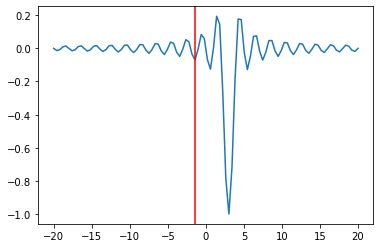

In [33]:
x = np.linspace(-20, 20, 100)
plt.plot(x, f(x, 3))
plt.axvline(scipy.optimize.minimize_scalar(f, args=(5,)).x, c='red')

### 3.1.2 Random start point
- Yields global minimum

In [34]:
lower = np.random.uniform(-20, 20, 100)
upper = lower + 1
sols = [scipy.optimize.minimize_scalar(f, args=(5,), bracket=(l, u)) for (l, u) in zip(lower, upper)]

In [35]:
idx = np.argmin([sol.fun for sol in sols]) #sol.fun
sol = sols[idx]

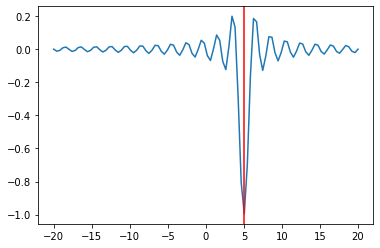

In [36]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red');

### 3.1.3 Stochastic algorithm

In [37]:
from scipy.optimize import basinhopping

x0 = 0
sol = basinhopping(f, x0, stepsize=1, minimizer_kwargs={'args': (5,)})
sol

                        fun: -1.0
 lowest_optimization_result:       fun: -1.0
 hess_inv: array([[0.30396607]])
      jac: array([1.49011612e-08])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([5.])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1686
                        nit: 100
                       njev: 562
                          x: array([5.])

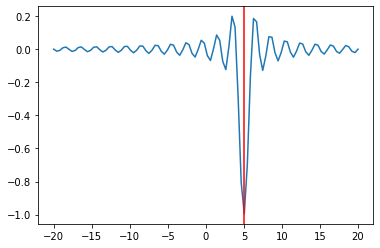

In [38]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red');

## 3.2 Multivariate minimization

### 3.2.1 Condition number
- Recall: condition number is largest eigenvalue/ smallest eigenvalue
- When the condition number is high, the gradient may not point in the direction of the minimum

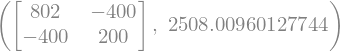

In [39]:
from sympy import symbols, hessian, Function, N

x, y = symbols('x y')
f = symbols('f', cls=Function)

f = 100*(y - x**2)**2 + (1 - x)**2

H = hessian(f, [x, y]).subs([(x,1), (y,1)])
H, N(H.condition_number())

### 3.2.2.1. Plot: Condition number
- [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function)

In [40]:
def rosen(x):
    """Generalized n-dimensional version of the Rosenbrock function"""
    return sum(100*(x[1:]-x[:-1]**2.0)**2.0 +(1-x[:-1])**2.0)
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

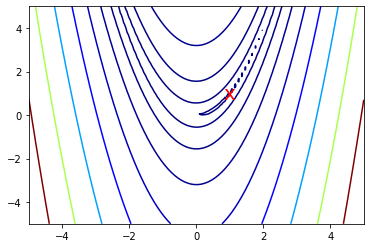

In [41]:
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20);

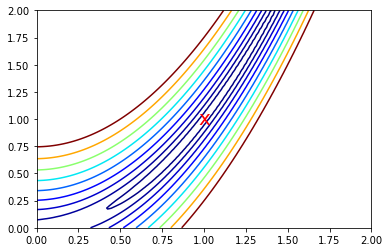

In [42]:
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, [rosen(np.array([k, k])) for k in np.linspace(1, 1.5, 10)], cmap='jet')
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20);

### 3.2.2 Gradient descent

In [43]:
def f(x):
    return x[0]**2 + x[1]**2

def grad(x):
    return np.array([2*x[0], 2*x[1]])

a = 0.1 # learning rate
x0 = np.array([1.0,1.0])
print('Start', x0)
for i in range(41):
    x0 -= a * grad(x0)
    if i%5 == 0:
        print(i, x0)

Start [1. 1.]
0 [0.8 0.8]
5 [0.262144 0.262144]
10 [0.08589935 0.08589935]
15 [0.0281475 0.0281475]
20 [0.00922337 0.00922337]
25 [0.00302231 0.00302231]
30 [0.00099035 0.00099035]
35 [0.00032452 0.00032452]
40 [0.00010634 0.00010634]


#### 3.2.2.1 Gradient descent: least squares

In [44]:
def f(x, y, b):
    """Helper function."""
    return (b[0] + b[1]*x - y)

def grad(x, y, b):
    """Gradient of objective function with respect to parameters b."""
    n = len(x)
    return np.array([
            sum(f(x, y, b)),
            sum(x*f(x, y, b))
    ])

x, y = map(np.array, zip((0,1), (1,2), (2,3), (3,3.5), (4,6), (5,9), (6,8)))

In [45]:
a = 0.001 # learning rate
b0 = np.zeros(2)
for i in range(10000):
    b0 -= a * grad(x, y, b0)
    if i%1000 == 0:
        print(b0)

[0.0325 0.1355]
[0.54071459 1.36439344]
[0.56745345 1.35808126]
[0.57091409 1.35726431]
[0.57136199 1.35715858]
[0.57141995 1.35714489]
[0.57142746 1.35714312]
[0.57142843 1.35714289]
[0.57142855 1.35714286]
[0.57142857 1.35714286]


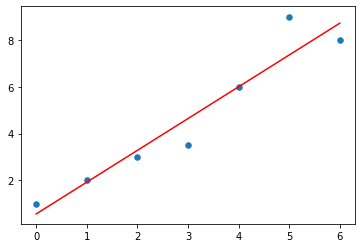

In [46]:
plt.scatter(x, y, s=30)
plt.plot(x, b0[0] + b0[1]*x, color='red');

# 4. Constrained Optimization and Lagrange Multipliers¶


## 4.1 Minimization with constraints

- F (x, y, z, λ, μ) = xy + yz − λ(x + 2y − 6) − μ(x − 3z)

In [47]:
A = np.array([
    [0, 1, 0, -1, -1],
    [1, 0, 1, -2, 0],
    [0, 1, 0, 0, 3],
    [1, 2, 0, 0, 0],
    [1, 0,-3, 0, 0]])

b = np.array([0,0,0,6,0])

sol = np.linalg.solve(A, b)
x,y,z, constraint1, constraint2 = sol
def f(x, y, z):
    return x*y + y*z
min_solu = -f(x,y,z)

print("Minimum of {} @ X:{}, Y:{}, Z:{}".format(min_solu,x,y,z))

Minimum of -6.0 @ X:3.0, Y:1.5, Z:1.0


### 4.1.1 Confirm 4.1.1 with scipy

In [48]:
def f(x):
    return -(x[0]*x[1] + x[1]*x[2]) #negative included for minmization

In [49]:
cons = ({'type': 'eq',
         'fun' : lambda x: np.array([x[0] + 2*x[1] - 6, x[0] - 3*x[2]])})

In [50]:
x0 = np.array([2,2,0.67])
cx = opt.minimize(f, x0, constraints=cons)
x,y,z = cx.x

In [51]:
print("Minimum of {:.1f} @ X:{:.1f}, Y:{:.1f}, Z:{:.1f}".format(cx.fun,x,y,z))

Minimum of -6.0 @ X:3.0, Y:1.5, Z:1.0


## 4.2 Graph: Min with constraints

In [52]:
def f(x):
    return -(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)

### 4.2.1 Unconstrained optimization

In [53]:
x0 = [0, 2.5]
ux = opt.minimize(f, x0, constraints=None)
ux

      fun: -1.9999999999996365
 hess_inv: array([[0.99829115, 0.50105608],
       [0.50105608, 0.4993548 ]])
      jac: array([ 1.25169754e-06, -1.41561031e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([2.00000043, 0.99999985])

### 4.2.2 Constrained optimization

In [54]:
cons = ({'type': 'eq',
         'fun' : lambda x: np.array([x[0]**3 - x[1]]),
         'jac' : lambda x: np.array([3.0*(x[0]**2.0), -1.0])},
        {'type': 'ineq',
         'fun' : lambda x: np.array([x[1] - (x[0]-1)**4 - 2])})

bnds = ((0.5, 1.5), (1.5, 2.5))

cx = opt.minimize(f, x0, bounds=bnds, constraints=cons)
cx

     fun: 2.049915472024102
     jac: array([-3.48747933,  5.49674535])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([1.26089314, 2.00463288])

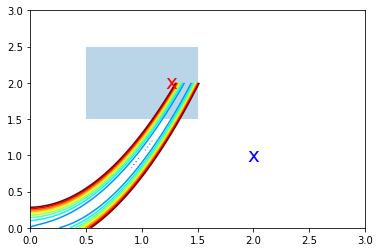

In [55]:
plt.contour(X, Y, Z, np.arange(-1.99,10, 1), cmap='jet');
plt.plot(x, x**3, 'k:', linewidth=1)
plt.plot(x, (x-1)**4+2, 'k:', linewidth=1)
plt.text(ux['x'][0], ux['x'][1], 'x', va='center', ha='center', size=20, color='blue')
plt.text(cx['x'][0], cx['x'][1], 'x', va='center', ha='center', size=20, color='red')
plt.fill([0.5,0.5,1.5,1.5], [2.5,1.5,1.5,2.5], alpha=0.3)
plt.axis([0,3,0,3]);